Example of accounting for a "trivial" selection function in a likelihood function.

In [61]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from scipy.special import erf

In [108]:
rng = np.random.default_rng(seed=42)
x = rng.normal(size=10_000)
ab = (-0.5, 0.2)
sel_x = x[(x < ab[0]) | (x > ab[1])]

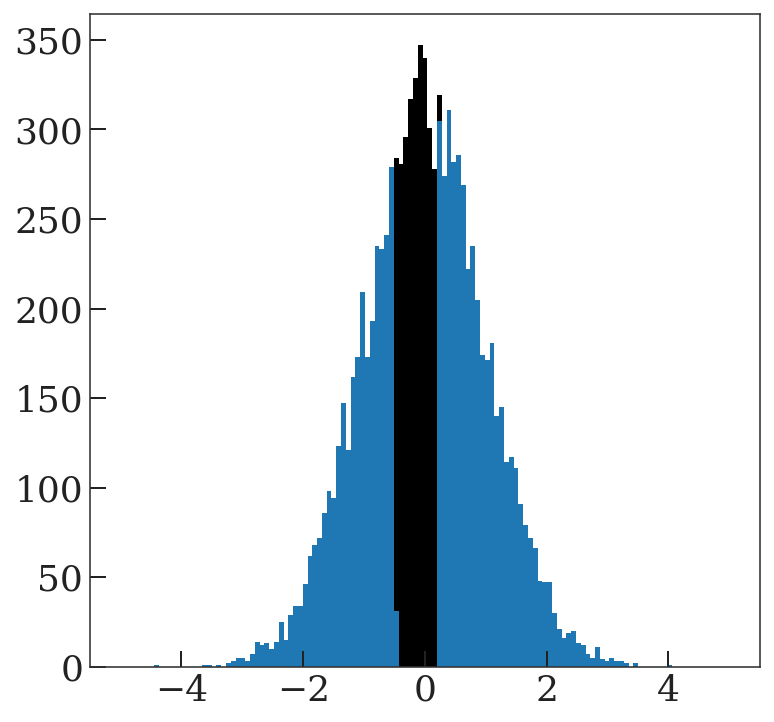

In [109]:
bins = np.linspace(-5, 5, 128)
plt.hist(x, bins=bins)
plt.hist(sel_x, bins=bins);

In [122]:
def ln_normal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)


def ln_likelihood(p, x):
    mu, lnstd = p
    std = np.exp(lnstd)
    return ln_normal(x, mu, std).sum()


def ln_likelihood2(p, x, a, b):
    mu, lnstd = p
    std = np.exp(lnstd)
    
    # this is like the effective volume, Veff
    factor = 0.5 * ((1 + erf((a - mu) / (np.sqrt(2) * std))) + 
                    (1 - erf((b - mu) / (np.sqrt(2) * std))))
    return (ln_normal(x, mu, std) - np.log(factor)).sum()

In [123]:
ln_likelihood([0, 0], x), ln_likelihood([0, 0], sel_x), ln_likelihood2([0, 0], sel_x, *ab)

(-14252.965871577657, -11636.99857295847, -9350.064082541787)

In [118]:
bootstrap_K = 256
rng = np.random.default_rng(seed=123)

opt_ps = []
for k in range(bootstrap_K):
    xx = rng.choice(x, size=len(x))
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=[0, 0], args=(xx, ), method='nelder-mead')
    opt_ps.append(res.x)
opt_ps = np.array(opt_ps)

# ---

sel_opt_ps = []
for k in range(bootstrap_K):
    xx = rng.choice(sel_x, size=len(sel_x))
    res = minimize(lambda *args: -ln_likelihood(*args), 
                   x0=[0, 0], args=(xx, ), method='nelder-mead')
    sel_opt_ps.append(res.x)
sel_opt_ps = np.array(sel_opt_ps)

# ---

sel_opt_ps2 = []
for k in range(bootstrap_K):
    xx = rng.choice(sel_x, size=len(sel_x))
    res = minimize(lambda *args: -ln_likelihood2(*args), 
                   x0=[0, 0], args=(xx, *ab), method='nelder-mead')
    sel_opt_ps2.append(res.x)
sel_opt_ps2 = np.array(sel_opt_ps2)

(-0.2, 0.2)

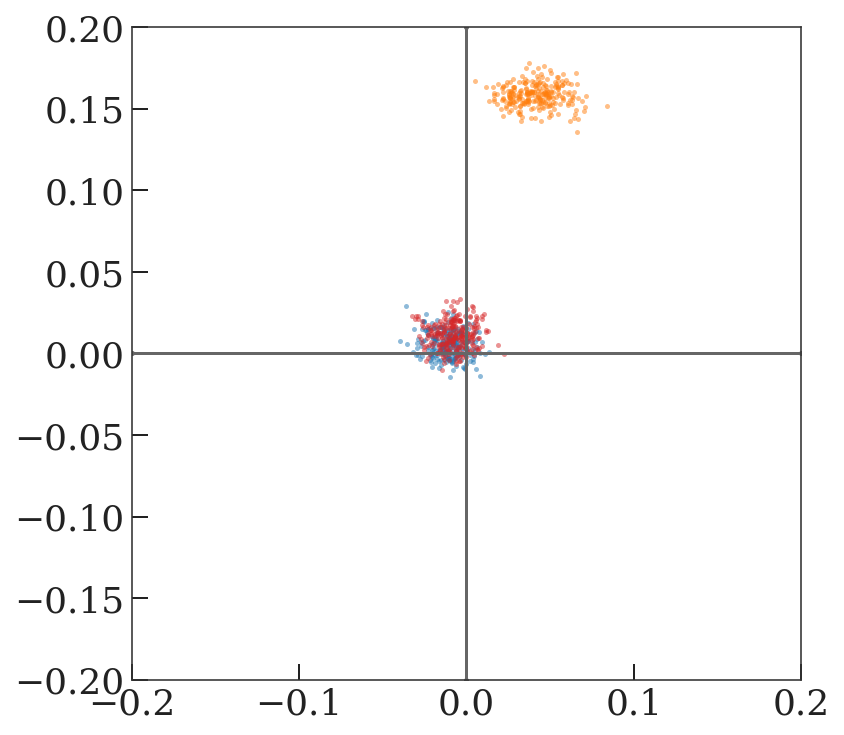

In [121]:
plt.plot(opt_ps[:, 0], opt_ps[:, 1], ls='none', 
         alpha=0.5, color='tab:blue')
plt.plot(sel_opt_ps[:, 0], sel_opt_ps[:, 1], ls='none', 
         alpha=0.5, color='tab:orange')
plt.plot(sel_opt_ps2[:, 0], sel_opt_ps2[:, 1], ls='none', 
         alpha=0.5, color='tab:red')
plt.axvline(0)
plt.axhline(0)

lim = (-0.2, 0.2)
plt.xlim(lim)
plt.ylim(lim)